In [4]:
%pip install requests
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.8 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.w

In [5]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file if it exists

# Use a GitHub token from an environment variable for authentication (if available)
GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN', '')  # or set your token here as a string

# Prepare a requests session for GitHub API calls
session = requests.Session()
if GITHUB_TOKEN:
    session.headers.update({"Authorization": f"token {GITHUB_TOKEN}"})
# GitHub API recommended headers
session.headers.update({"Accept": "application/vnd.github+json"})
session.headers.update({"X-GitHub-Api-Version": "2022-11-28"})


In [6]:
# Define the target languages for repository primary language
languages = ["TypeScript", "Python", "Go", "Rust", "C", "C++"]  # "C/C++" means both C and C++
# Construct the search query for these languages (multiple language qualifiers act as an OR in search)
language_query = " ".join(f"language:{lang}" for lang in languages)

search_url = "https://api.github.com/search/repositories"
per_page = 20
page = 1

popular_repos = []  # to collect repository data


In [22]:
# Helper function to get all pages of results for a GitHub API endpoint that may paginate
def get_all_pages(url, params=None):
    """Fetch all pages of results from a GitHub API GET endpoint (combines 'Link' header pagination)."""
    results = []
    while url:
        response = session.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        # Some endpoints return a list directly, others (like search) return dict with 'items'
        if isinstance(data, dict) and "items" in data:
            items = data["items"]
        else:
            items = data
        results.extend(items)
        # Check for pagination in the "Link" header
        link_header = response.headers.get("Link", "")
        next_url = None
        if link_header:
            # Parse the Link header to find the URL for next page
            parts = link_header.split(",")
            for part in parts:
                if 'rel="next"' in part:
                    # Extract the next page URL from angle brackets <>
                    start = part.find("<") + 1
                    end = part.find(">")
                    next_url = part[start:end]
                    break
        url = next_url  # if next_url is None, loop will exit
        params = None   # Only pass params on first request
    return results

# Hardcoded ignore list - repositories to skip in the analysis
ignore_list = {
    "freeCodeCamp/freeCodeCamp",
    "EbookFoundation/free-programming-books", 
    "public-apis/public-apis",
    "kamranahmedse/developer-roadmap",
    "donnemartin/system-design-primer",
    "vinta/awesome-python"
}

selected_repos = []  # repositories with >=3 contributors
contributors_dict = {}  # to store contributor login sets for each repo

print("Starting repository collection...")
print(f"Target: 20 repositories with >1 contributors")
print(f"Ignoring {len(ignore_list)} repositories from ignore list")
print("-" * 60)

# Loop through search result pages until we have at least 20 qualified repositories
while len(selected_repos) < 20:
    print(f"\n📄 Fetching page {page} of search results...")
    params = {"q": language_query, "sort": "stars", "order": "desc", "per_page": per_page, "page": page}
    response = session.get(search_url, params=params)
    response.raise_for_status()
    search_data = response.json()
    repo_items = search_data.get("items", [])
    if not repo_items:
        print("❌ No more results found")
        break  # no more results
    
    print(f"Found {len(repo_items)} repositories on this page")
    
    for i, repo in enumerate(repo_items, 1):
        print(f"\n🔍 [{i}/{len(repo_items)}] Checking: {repo['full_name']} (⭐ {repo['stargazers_count']}, {repo.get('language')})")
        
        # Skip repositories in the ignore list
        if repo["full_name"] in ignore_list:
            print(f"⏭️  Skipping ignored repository: {repo['full_name']}")
            continue
            
        # Fetch all contributors for this repo (contributors endpoint is publicly accessible)
        owner = repo["owner"]["login"]
        repo_name = repo["name"]
        contributors_url = f"https://api.github.com/repos/{owner}/{repo_name}/contributors"
        
        print(f"   Fetching contributors...")
        try:
            contributors = get_all_pages(contributors_url, params={"per_page": 100})
            print(f"   Found {len(contributors)} contributors")
            
            if len(contributors) > 1:  # more than 1 contributor
                selected_repos.append(repo)
                # Store the set of contributor usernames for later checking comments
                contributors_set = {contributor["login"] for contributor in contributors}
                contributors_dict[repo["full_name"]] = contributors_set
                print(f"✅ Added to selection ({len(selected_repos)}/20): {repo['full_name']}")
            else:
                print(f"❌ Skipping: Only {len(contributors)} contributor(s)")
                
        except requests.exceptions.HTTPError as e:
            # Skip repositories where we can't access contributors (e.g., private repos)
            print(f"❌ Skipping {repo['full_name']}: {e}")
            continue
            
        if len(selected_repos) >= 20:
            print(f"\n🎉 Target reached! Found {len(selected_repos)} repositories")
            break
    page += 1

print("\n" + "=" * 60)
# Check how many repositories we collected
print(f"✅ Collected {len(selected_repos)} repositories with >=2 contributors.")
print("\nSelected repositories:")
for repo in selected_repos:
    print(f"- {repo['full_name']} (Primary language: {repo.get('language')}, ⭐ {repo['stargazers_count']})")

Starting repository collection...
Target: 20 repositories with >1 contributors
Ignoring 6 repositories from ignore list
------------------------------------------------------------

📄 Fetching page 4 of search results...
Found 20 repositories on this page

🔍 [1/20] Checking: home-assistant/core (⭐ 79733, Python)
   Fetching contributors...
Found 20 repositories on this page

🔍 [1/20] Checking: home-assistant/core (⭐ 79733, Python)
   Fetching contributors...
   Found 415 contributors
✅ Added to selection (1/20): home-assistant/core

🔍 [2/20] Checking: 3b1b/manim (⭐ 78285, Python)
   Fetching contributors...
   Found 415 contributors
✅ Added to selection (1/20): home-assistant/core

🔍 [2/20] Checking: 3b1b/manim (⭐ 78285, Python)
   Fetching contributors...
   Found 164 contributors
✅ Added to selection (2/20): 3b1b/manim

🔍 [3/20] Checking: tensorflow/models (⭐ 77584, Python)
   Fetching contributors...
   Found 164 contributors
✅ Added to selection (2/20): 3b1b/manim

🔍 [3/20] Checkin

In [23]:
# Prepare lists to collect lead times
lead_times_groupA = []  # issues with >=2 maintainer commenters
lead_times_groupB = []  # issues with <=1 maintainer commenter

analysed_repos = selected_repos[:2] # FIXME: TMP!

print("Starting issue analysis for lead time calculation...")
print(f"Analyzing {len(analysed_repos)} repositories")
print("Group A: Issues with >=2 maintainer commenters")
print("Group B: Issues with <=1 maintainer commenter")
print("=" * 70)

for repo_idx, repo in enumerate(analysed_repos, 1):
    full_name = repo["full_name"]
    owner = repo["owner"]["login"]
    repo_name = repo["name"]

    print(f"\n📁 [{repo_idx}/{len(analysed_repos)}] Processing repository: {full_name}")
    print(f"   Language: {repo.get('language')}, Stars: ⭐ {repo['stargazers_count']}")
    
    # Use GitHub Search API to fetch only issues (not pull requests) that are closed
    search_issues_url = "https://api.github.com/search/issues"
    search_query = f"repo:{full_name} type:issue state:closed"
    print(f"   🔍 Fetching closed issues only (excluding pull requests)...")
    
    # Get all closed issues using search API (this excludes PRs automatically)
    search_response = get_all_pages(search_issues_url, params={"q": search_query, "per_page": 100})
    # Extract the actual issues from search results
    issues = search_response if isinstance(search_response, list) else []
    
    print(f"   📝 Found {len(issues)} closed issues (pull requests excluded)")
    
    maintainers_set = contributors_dict.get(full_name, set())
    print(f"   👥 Repository has {len(maintainers_set)} contributors")
    
    # Counters for this repository
    repo_issues_processed = 0
    repo_groupA_added = 0
    repo_groupB_added = 0
    
    # Process each issue
    for issue_idx, issue in enumerate(issues, 1):
        if issue_idx % 200 == 0 or issue_idx == len(issues):
            print(f"      Processing item {issue_idx}/{len(issues)}...")
            
        # No need to check for pull requests anymore since we're using type:issue filter
        
        # Calculate lead time from creation to closing
        created = issue.get("created_at")
        closed = issue.get("closed_at")
        if not closed or not created:
            continue  # skip if missing timestamps (shouldn't happen for closed issues)
            
        # Parse timestamps to datetime objects
        # Using built-in datetime parsing; assuming timestamps are in ISO 8601 (e.g. "2021-07-19T09:23:43Z")
        from datetime import datetime
        created_dt = datetime.fromisoformat(created.replace("Z", "+00:00"))
        closed_dt = datetime.fromisoformat(closed.replace("Z", "+00:00"))
        
        # Lead time in days (as float)
        lead_time_days = (closed_dt - created_dt).total_seconds() / (60*60*24)
        
        # Determine how many unique maintainers commented on this issue
        maint_commenters = 0
        if issue.get("comments", 0) == 0:
            # No comments at all
            maint_commenters = 0
        elif issue.get("comments", 0) == 1:
            # Only one comment; check if it was by a maintainer
            comments_url = issue["comments_url"]
            comment_data = get_all_pages(comments_url)
            # comment_data could be a list of one comment (if we have permission), or empty if not accessible
            if isinstance(comment_data, list) and comment_data:
                commenter_login = comment_data[0]["user"]["login"]
                maint_commenters = 1 if commenter_login in maintainers_set else 0
            else:
                # If comment not accessible, assume 0 maintainers for safety
                maint_commenters = 0
        else:
            # Multiple comments, fetch all comments and count unique maintainers among commenters
            comments_url = issue["comments_url"]
            all_comments = get_all_pages(comments_url)
            # Get unique logins of commenters who are maintainers
            maintainer_commenters = {c["user"]["login"] for c in all_comments if c["user"]["login"] in maintainers_set}
            maint_commenters = len(maintainer_commenters)
            
        # Categorize issue based on maintainer commenter count
        if maint_commenters >= 2:
            lead_times_groupA.append(lead_time_days)
            repo_groupA_added += 1
        else:
            lead_times_groupB.append(lead_time_days)
            repo_groupB_added += 1
            
        repo_issues_processed += 1

    # Repository summary
    print(f"   ✅ Repository complete:")
    print(f"      • {repo_issues_processed} issues processed (PRs automatically excluded)")
    print(f"      • {repo_groupA_added} → Group A (>=2 maintainer commenters)")
    print(f"      • {repo_groupB_added} → Group B (<=1 maintainer commenter)")
    print(f"   📊 Running totals: Group A={len(lead_times_groupA)}, Group B={len(lead_times_groupB)}")

print("\n" + "=" * 70)
print("🎉 Issue analysis complete!")
print(f"📊 Final Results:")
print(f"   • Total repositories analyzed: {len(analysed_repos)}")
print(f"   • Group A (>=2 maintainer commenters): {len(lead_times_groupA)} issues")
print(f"   • Group B (<=1 maintainer commenter): {len(lead_times_groupB)} issues")
print(f"   • Total issues analyzed: {len(lead_times_groupA) + len(lead_times_groupB)}")

if lead_times_groupA:
    print(f"   • Group A average lead time: {sum(lead_times_groupA)/len(lead_times_groupA):.1f} days")
if lead_times_groupB:
    print(f"   • Group B average lead time: {sum(lead_times_groupB)/len(lead_times_groupB):.1f} days")

Starting issue analysis for lead time calculation...
Analyzing 2 repositories
Group A: Issues with >=2 maintainer commenters
Group B: Issues with <=1 maintainer commenter

📁 [1/2] Processing repository: home-assistant/core
   Language: Python, Stars: ⭐ 79733
   🔍 Fetching closed issues only (excluding pull requests)...
   📝 Found 1000 closed issues (pull requests excluded)
   👥 Repository has 415 contributors
   📝 Found 1000 closed issues (pull requests excluded)
   👥 Repository has 415 contributors
      Processing item 200/1000...
      Processing item 200/1000...
      Processing item 400/1000...
      Processing item 400/1000...
      Processing item 600/1000...
      Processing item 600/1000...
      Processing item 800/1000...
      Processing item 800/1000...
      Processing item 1000/1000...
      Processing item 1000/1000...
   ✅ Repository complete:
      • 1000 issues processed (PRs automatically excluded)
      • 93 → Group A (>=2 maintainer commenters)
      • 907 → Group

In [29]:
# Calculate median lead times for both groups
median_A = np.median(lead_times_groupA) if lead_times_groupA else float('nan')
median_B = np.median(lead_times_groupB) if lead_times_groupB else float('nan')

print(f"\nMedian lead time for issues with >=2 maintainer commenters (Group A): {median_A:.2f} days")
print(f"Median lead time for issues with <=1 maintainer commenter (Group B): {median_B:.2f} days")


Median lead time for issues with >=2 maintainer commenters (Group A): 6.05 days
Median lead time for issues with <=1 maintainer commenter (Group B): 1.23 days


In [30]:
# Filter outliers using IQR method for better visualization
def remove_outliers_iqr(data, multiplier=1.5):
    """Remove outliers using the Interquartile Range (IQR) method"""
    if not data:
        return []
    
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    outliers_removed = len(data) - len(filtered_data)
    
    return filtered_data, outliers_removed, lower_bound, upper_bound

# Filter outliers from both groups
lead_times_groupA_filtered, outliers_A, lower_A, upper_A = remove_outliers_iqr(lead_times_groupA)
lead_times_groupB_filtered, outliers_B, lower_B, upper_B = remove_outliers_iqr(lead_times_groupB)

print("Outlier filtering results:")
print(f"Group A: {len(lead_times_groupA)} → {len(lead_times_groupA_filtered)} issues ({outliers_A} outliers removed)")
print(f"  Range after filtering: {lower_A:.1f} to {upper_A:.1f} days")
print(f"Group B: {len(lead_times_groupB)} → {len(lead_times_groupB_filtered)} issues ({outliers_B} outliers removed)")
print(f"  Range after filtering: {lower_B:.1f} to {upper_B:.1f} days")


Outlier filtering results:
Group A: 221 → 178 issues (43 outliers removed)
  Range after filtering: -41.8 to 72.9 days
Group B: 1538 → 1313 issues (225 outliers removed)
  Range after filtering: -13.1 to 22.4 days


In [31]:

# Calculate appropriate X-axis limit based on filtered data
max_lead_time = max(
    max(lead_times_groupA_filtered) if lead_times_groupA_filtered else 0,
    max(lead_times_groupB_filtered) if lead_times_groupB_filtered else 0
)
x_limit = min(max_lead_time * 1.1, 365)  # Cap at 1 year for readability

print(f"\nChart X-axis limit set to: {x_limit:.0f} days")



Chart X-axis limit set to: 77 days


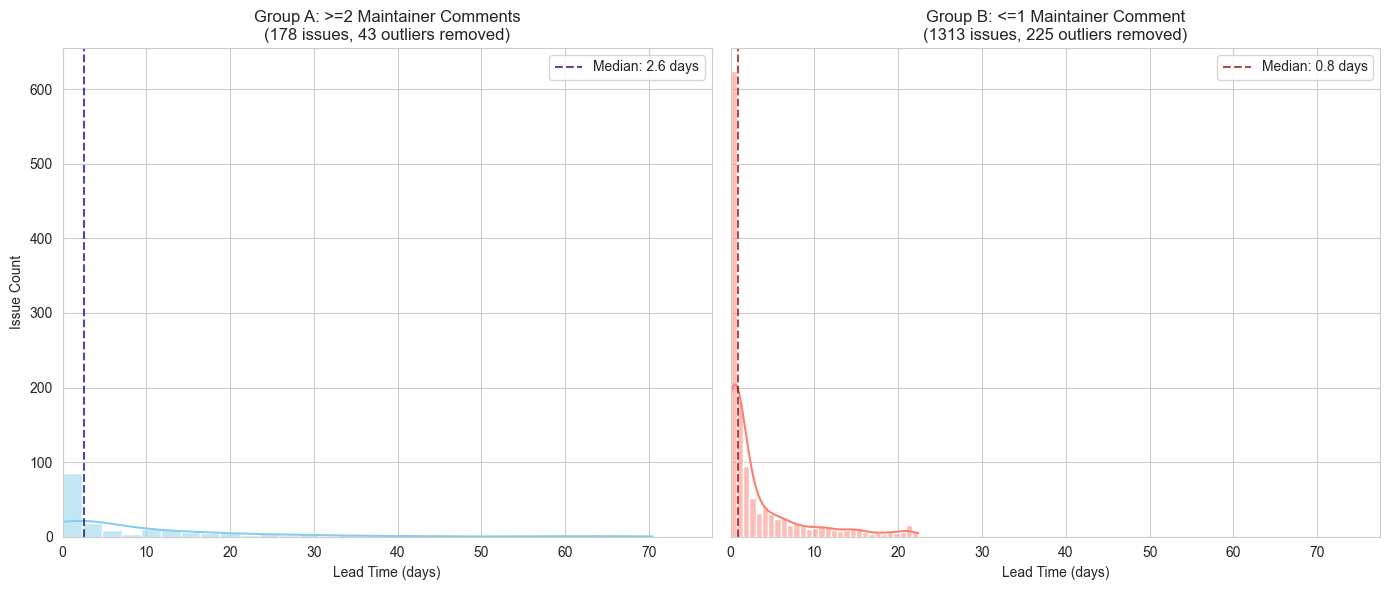

In [32]:

# Plot distributions of lead times for both groups (filtered)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Group A distribution plot
if lead_times_groupA_filtered:
    sns.histplot(lead_times_groupA_filtered, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].axvline(np.median(lead_times_groupA_filtered), color='navy', linestyle='--', alpha=0.7, 
                   label=f'Median: {np.median(lead_times_groupA_filtered):.1f} days')
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'No data after filtering', transform=axes[0].transAxes, ha='center')

axes[0].set_title(f'Group A: >=2 Maintainer Comments\n({len(lead_times_groupA_filtered)} issues, {outliers_A} outliers removed)')
axes[0].set_xlabel('Lead Time (days)')
axes[0].set_ylabel('Issue Count')
axes[0].set_xlim(0, x_limit)

# Group B distribution plot
if lead_times_groupB_filtered:
    sns.histplot(lead_times_groupB_filtered, kde=True, ax=axes[1], color='salmon', bins=30)
    axes[1].axvline(np.median(lead_times_groupB_filtered), color='darkred', linestyle='--', alpha=0.7,
                   label=f'Median: {np.median(lead_times_groupB_filtered):.1f} days')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'No data after filtering', transform=axes[1].transAxes, ha='center')

axes[1].set_title(f'Group B: <=1 Maintainer Comment\n({len(lead_times_groupB_filtered)} issues, {outliers_B} outliers removed)')
axes[1].set_xlabel('Lead Time (days)')
axes[1].set_ylabel('Issue Count')
axes[1].set_xlim(0, x_limit)

plt.tight_layout()
plt.show()


In [33]:

# Print summary statistics for filtered data
print(f"\nSummary statistics (after outlier removal):")
if lead_times_groupA_filtered:
    print(f"Group A (>=2 maintainer comments):")
    print(f"  • Count: {len(lead_times_groupA_filtered)} issues")
    print(f"  • Median: {np.median(lead_times_groupA_filtered):.1f} days")
    print(f"  • Mean: {np.mean(lead_times_groupA_filtered):.1f} days")
    print(f"  • Range: {min(lead_times_groupA_filtered):.1f} - {max(lead_times_groupA_filtered):.1f} days")

if lead_times_groupB_filtered:
    print(f"Group B (<=1 maintainer comment):")
    print(f"  • Count: {len(lead_times_groupB_filtered)} issues")
    print(f"  • Median: {np.median(lead_times_groupB_filtered):.1f} days")
    print(f"  • Mean: {np.mean(lead_times_groupB_filtered):.1f} days")
    print(f"  • Range: {min(lead_times_groupB_filtered):.1f} - {max(lead_times_groupB_filtered):.1f} days")


Summary statistics (after outlier removal):
Group A (>=2 maintainer comments):
  • Count: 178 issues
  • Median: 2.6 days
  • Mean: 9.5 days
  • Range: 0.0 - 70.4 days
Group B (<=1 maintainer comment):
  • Count: 1313 issues
  • Median: 0.8 days
  • Mean: 3.1 days
  • Range: 0.0 - 22.4 days
